In [1]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from tqdm import tqdm

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

### 8.1 The infinite square well
The standard problem in quantum mechanics is the particle in a box, where the Schrodinger equation is given by
$$ -\frac{1}{2}\frac{\mathrm{d}^2\psi}{\mathrm{d}x^2} = E\psi $$

In [2]:
class PhysicsInformed(nn.Module):
    def __init__(self, N_hidden_depth=2, N_hidden_width=16):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, N_hidden_width),
            nn.SiLU(),
            *[action for action_pair in \
              [(nn.Linear(N_hidden_width, N_hidden_width), nn.SiLU(),) for _ in range(N_hidden_depth - 1)] \
              for action in action_pair],
            nn.Linear(N_hidden_width, 1))
        self.E = nn.Parameter(torch.rand(1), requires_grad=True)
        self.N_epochs_trained = 0
    
    def forward(self, x):
        return self.layers(x)
    
    def prediction_and_derivatives(self, x):
        prediction = self.forward(x)
        derivative = torch.autograd.grad(prediction, x, torch.ones_like(prediction), create_graph=True)[0]
        second_derivative = torch.autograd.grad(derivative, x, torch.ones_like(prediction), create_graph=True)[0]
        return prediction, derivative, second_derivative

In [3]:
def train(model, x0s, y0s_target, optimizer, criterion, epochs=2500, xmin=-0.5, xmax=0.5, perturbation=None):
    x0s = torch.tensor(x0s, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    y0s_target = torch.tensor(y0s_target, dtype=torch.float32).reshape(-1, 1)
    xds = torch.linspace(xmin, xmax, 100, dtype=torch.float32, requires_grad=True).reshape(-1, 1)

    for epoch in tqdm(range(epochs), desc=f'Training {model.__class__.__name__}'):
        xs = torch.sort(torch.rand((32, 1), dtype=torch.float32, requires_grad=True), dim=0)[0] * (xmax - xmin) + xmin
        optimizer.zero_grad()

        # Schrödinger equation
        y, _, d2ydx2 = model.prediction_and_derivatives(xs)
        if perturbation is None:
            loss = criterion(-0.5*d2ydx2, model.E*y)
        else:
            loss = criterion(-0.5*d2ydx2 + perturbation(xs)*y, model.E*y)

        # Boundary condition
        y0s_predicted = model.forward(x0s)
        loss += criterion(y0s_predicted, y0s_target)

        # Normalization
        psi = model.forward(xds).flatten()
        norm = torch.trapz(psi**2, xds.flatten())
        loss += 10*criterion(norm.reshape(-1, 1), torch.tensor([1], dtype=torch.float32).reshape(-1, 1))

        loss.backward()
        optimizer.step()

Training PhysicsInformed: 100%|██████████| 1000/1000 [00:05<00:00, 189.71it/s]


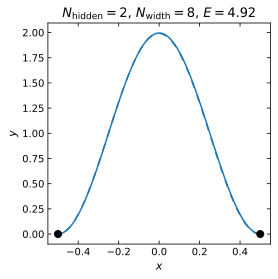

In [4]:
width = 8
depth = 2
model0 = PhysicsInformed(N_hidden_depth=depth, N_hidden_width=width)
lr = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model0.parameters(), lr=lr)

fig, ax = plt.subplots(figsize=(4,4))
x0s = [-0.5, 0.5]
y0s_target = [0, 0]

for i, (xmin, xmax) in enumerate([x0s]):
    for j, (epochs, linestyle) in enumerate(zip([10000, 1000], ['solid', (5, (5,5))])):
        train(model0, x0s, y0s_target, optimizer, criterion, epochs=epochs, xmin=xmin, xmax=xmax)
        xs = torch.linspace(xmin, xmax, 100).reshape(-1, 1)
        ys = model0(xs)
        ax.plot(xs.detach(), ys.detach()**2, c=f'C{i}', ls=linestyle)
    ax.scatter(x0s, y0s_target, s=50, c='k', zorder=10)
    ax.set(xlabel='$x$', ylabel='$y$', title=fr'$N_{{\rm hidden}}={depth}$, $N_{{\rm width}}={width}$, $E={model0.E.item():.2f}$')

fig.savefig('ex67_fig1.png')

### 8.2 Perturbation
Now add a perturbation to the perfect square well potential (choose your own shape and strength!).

In [5]:
def perturbation(xs):
    perts = torch.zeros_like(xs)
    perts += strength * (xs > domain[0]) * (xs < domain[1])
    return perts

Training PhysicsInformed:   0%|          | 0/10000 [00:00<?, ?it/s]

Training PhysicsInformed: 100%|██████████| 1000/1000 [00:03<00:00, 271.02it/s]


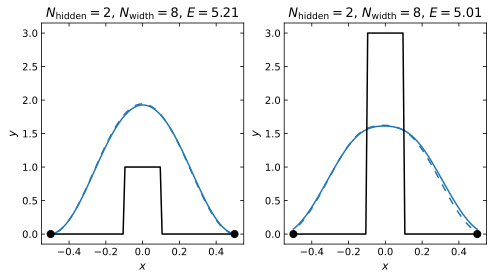

In [6]:
width = 8
depth = 2
lr = 1e-3
criterion = nn.MSELoss()
domain = [-0.1, 0.1]
strengths = [1, 3]

fig, axes = plt.subplots(1, 2, figsize=(8,4))
x0s = [-0.5, 0.5]
y0s_target = [0, 0]

for ax, strength in zip(axes, strengths):
    model = PhysicsInformed(N_hidden_depth=depth, N_hidden_width=width)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for i, (xmin, xmax) in enumerate([x0s]):
        for j, (epochs, linestyle) in enumerate(zip([10000, 1000], ['solid', (5, (5,5))])):
            train(model, x0s, y0s_target, optimizer, criterion, epochs=epochs, xmin=xmin, xmax=xmax, perturbation=perturbation)
            xs = torch.linspace(xmin, xmax, 100).reshape(-1, 1)
            ys = model(xs)
            ax.plot(xs.detach(), ys.detach()**2, c=f'C{i}', ls=linestyle)
        ax.scatter(x0s, y0s_target, s=50, c='k', zorder=10)
        ax.set(xlabel='$x$', ylabel='$y$', title=fr'$N_{{\rm hidden}}={depth}$, $N_{{\rm width}}={width}$, $E={model.E.item():.2f}$')
    ax.plot(xs.detach(), perturbation(xs).detach(), c='k', ls='-')

y_min = min(ax.get_ylim()[0] for ax in axes)
y_max = max(ax.get_ylim()[1] for ax in axes)
for ax in axes:
    ax.set_ylim(y_min, y_max)

fig.savefig('ex67_fig2.png')